In [56]:
"""
@authors: faurand, chardes, ehagensieker
"""
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime
import tqdm
import pprint

In [57]:
# add an empty dimension and scale the images to values between 0 and 1
normalize = lambda x: tf.cast(tf.expand_dims(x, -1), tf.float32) / 255.

# add noise to the image   
add_noise = lambda x, e: tf.clip_by_value(x + e * tf.random.normal(mean=0., stddev=1., shape=x.shape),
                                          clip_value_min=0.,
                                          clip_value_max=1.)

def prepare_data(ds, noise_level=0.4, batch_size=32):
    # apply lambda functions
    ds = ds.map(lambda x,t: (normalize(x), normalize(t)))
    ds = ds.map(lambda x,t: (add_noise(x, noise_level), t))
    
    # shuffle, batch, prefetch
    ds = ds.cache().shuffle(1028).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return ds

def plot_images(ds, img_size=(28,28)):
    fig, ax = plt.subplots(nrows=2, ncols=10, figsize=(22,5))

    for noisy_images, original_images in ds.take(1):
        for i in range(10): 
            ax[0,i].imshow(noisy_images[i].numpy().reshape(img_size))
            ax[0,i].set(title='noisy image')
            ax[1,i].imshow(original_images[i].numpy().reshape(img_size))
            ax[1,i].set(title='original image')

    plt.show();

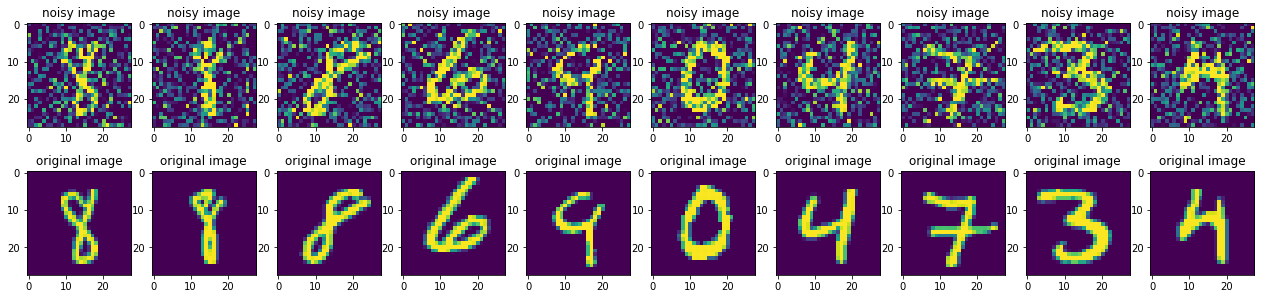

In [58]:
# load the dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# set the originial images as targets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, X_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, X_test))

# prepare the dataset
train_ds = prepare_data(train_ds)
test_ds = prepare_data(test_ds)

# plot the noisy images and the original target images
plot_images(train_ds)

In [59]:
from keras.layers import Conv2D, Dense, Flatten, BatchNormalization, Dropout

class Encoder(tf.keras.layers.Layer):

    def __init__(self, latent_dim):
        super(Encoder, self).__init__()

        self.layer_list =  [tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(2,2), padding = 'same', activation = 'relu', input_shape=(28,28,1)),
                            tf.keras.layers.BatchNormalization(),
                            tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), padding = 'same', activation = 'relu'),
                            tf.keras.layers.BatchNormalization(),
                            tf.keras.layers.Flatten(),
                            tf.keras.layers.Dropout(0.5),
                            tf.keras.layers.Dense(latent_dim, activation='sigmoid')]

    def call(self, x , training=False):
        for layer in self.layer_list:
            x = layer(x)
        return x

In [60]:
from keras.layers import Conv2DTranspose

class Decoder(tf.keras.Model):

    def __init__(self, latent_dim):
        super(Decoder, self).__init__()

        self.layer_list =  [tf.keras.layers.Dense(3136, activation='relu', input_shape=(latent_dim,)),
                            tf.keras.layers.BatchNormalization(),
                            tf.keras.layers.Reshape((7,7,64)),
                            tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'),
                            tf.keras.layers.BatchNormalization(),
                            tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'),
                            tf.keras.layers.BatchNormalization(),
                            tf.keras.layers.Conv2D(1, kernel_size=(3, 3), padding='same', activation='sigmoid')]

    def call(self, x , training=False):
        for layer in self.layer_list:
            x = layer(x)
        return x

In [61]:
class Autoencoder(tf.keras.Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()

        self.metrics_list = [tf.keras.metrics.Mean(name="loss"),
                             tf.keras.metrics.BinaryAccuracy(name="acc")]

        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def call(self, x, training=False):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded       

    @property
    def metrics(self):
        return self.metrics_list

    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_states()

    @tf.function 
    def train_step(self, data):
        x, t = data
        
        with tf.GradientTape() as tape:
            output = self(x, training = True)
            loss = self.compiled_loss(t, output, regularization_losses=self.losses)
        
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        self.metrics[0].update_state(loss)
        self.metrics[1].update_state(t, output)

        return {m.name : m.result() for m in self.metrics}

    @tf.function
    def test_step(self, data):
        x, t = data
        
        output = self(x, training=False)
        loss = self.compiled_loss(t, output, regularization_losses=self.losses)
                
        self.metrics[0].update_state(loss)
        self.metrics[1].update_state(t, output)
        
        return {m.name : m.result() for m in self.metrics}

In [62]:
model = Autoencoder(15)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.BinaryCrossentropy()

# compile the model
model.compile(optimizer=optimizer, loss=loss)

In [63]:
EXPERIMENT_NAME = "denoising_autoencoder"
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logging_callback = tf.keras.callbacks.TensorBoard(log_dir=f"./logs/{EXPERIMENT_NAME}/{current_time}")

In [64]:
history = model.fit(train_ds,
                    validation_data=test_ds,
                    initial_epoch=0,
                    epochs=10,
                    callbacks=[logging_callback])

Epoch 1/10
1875/1875 [==============================] - 20s 10ms/step - loss: 0.1657 - acc: 0.7989 - val_loss: 0.1278 - val_acc: 0.8097
Epoch 2/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.1245 - acc: 0.8092 - val_loss: 0.1276 - val_acc: 0.8045
Epoch 3/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.1206 - acc: 0.8098 - val_loss: 0.1159 - val_acc: 0.8091
Epoch 4/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.1185 - acc: 0.8101 - val_loss: 0.1144 - val_acc: 0.8090
Epoch 5/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.1173 - acc: 0.8103 - val_loss: 0.1120 - val_acc: 0.8090
Epoch 6/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.1163 - acc: 0.8105 - val_loss: 0.1106 - val_acc: 0.8095
Epoch 7/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.1157 - acc: 0.8106 - val_loss: 0.1134 - val_acc: 0.8082
Epoch 8/10
1875/1875 [==============================] 

In [65]:
def visualize_training(history):
    fig, ax = plt.subplots(1,2, figsize=(12,4))

    ax[0].plot(history.history["loss"])
    ax[0].plot(history.history["val_loss"])
    ax[0].legend(labels=["training loss","validation loss"])

    ax[1].plot(history.history["acc"])
    ax[1].plot(history.history["val_acc"])
    ax[1].legend(labels=["training accuracy","validation accuracy"])

def show_reconstructions(model, ds, img_size=(28,28)):
    fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(12,8))
    
    for noisy_images, original_images in test_ds.take(1):
        reconstructions = model(noisy_images, training=False)
        for i in range(5):
            ax[0,i].imshow(noisy_images[i].numpy().reshape(img_size))
            ax[0,i].set(title='noisy image')
            ax[1,i].imshow(original_images[i].numpy().reshape(img_size))
            ax[1,i].set(title='original image')
            ax[2,i].imshow(reconstructions[i].numpy().reshape(img_size))
            ax[2,i].set(title='denoised image')

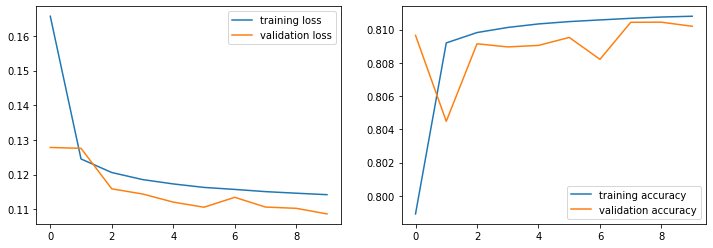

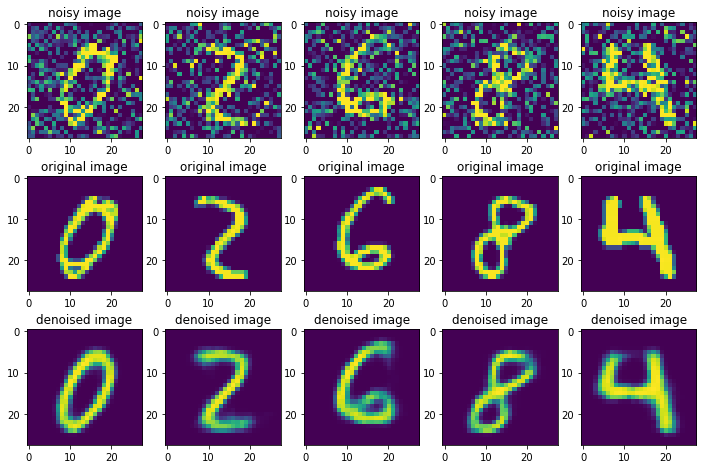

In [66]:
visualize_training(history)
show_reconstructions(model, test_ds)

In [ ]:
from sklearn.manifold import TSNE

# embed the first 1000 images of the test set using the encoder
data = normalize(X_test[:1000])
labels = y_test[:1000]
embedding = model.encoder(data)
tsne = TSNE(n_components=2).fit_transform(embedding)

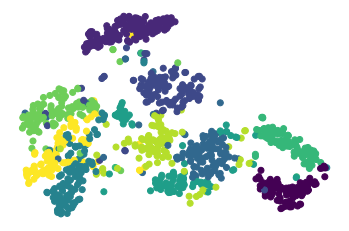

In [68]:
# plot the data points, coloured according to their class
plt.scatter(tsne[:,0], tsne[:,1], c=labels)
plt.axis("off")
plt.show();

The different digits build clusters that are mostly seperat from each other. Digits that are similar two each other (like seven and one) have embeddings that are closer together in latent space. 

In [69]:
#  interpolate linearly between the embeddings of a seven and a one
ipn = [embedding[0] * i * .1 + embedding[2] * (10 - i) * .1 for i in range(10)]
reconstructed = model.decoder(tf.convert_to_tensor(ipn))

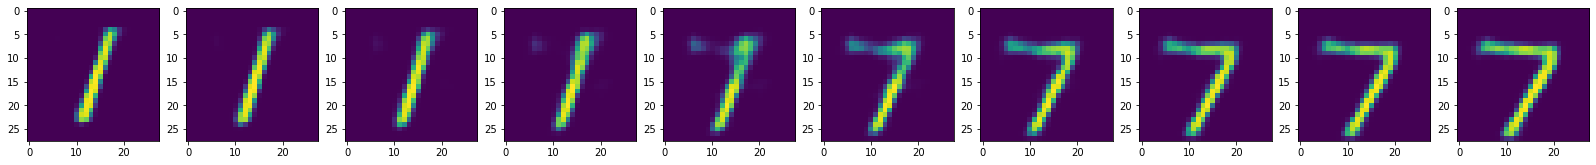

In [70]:
# plot the reconstructed images
plt.figure(figsize=(28,7))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(reconstructed[i].numpy().reshape((28,28)))